In [ ]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 0. Data load

In [ ]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
df_cleaned = df[['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining', 'midPrice']].copy()
df_cleaned = df_cleaned.dropna()
df_cleaned['inTheMoney'] = df_cleaned['inTheMoney'].astype('category')
df_cleaned.info()

In [ ]:
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64'])
categorical_cols = df_cleaned.select_dtypes(include=['category'])

### 2. Data split

In [ ]:
INPUTS = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'price', 'duration', 'remaining']
OUTPUT= 'midPrice'

X = df_cleaned[INPUTS]
y = df_cleaned[OUTPUT]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

In [ ]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

In [ ]:
INPUTS_MLP_NUM = ['strike', 'volume', 'openInterest', 'impliedVolatility', 'price', 'duration', 'remaining']
INPUTS_MLP_CAT = ['inTheMoney']
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.01, 0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(60,)],
         'MLP__learning_rate_init': [0.001, 0.01],
         'MLP__activation': ['relu', 'tanh']
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', 
                max_iter=2000, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid


# Save the model
import joblib
joblib.dump(MLP_fit, '../models/MLP_fit_complete.pkl')


In [ ]:
import joblib
MLP_fit = joblib.load('../models/MLP_fit_complete.pkl')

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plotModelGridError(MLP_fit):
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']
    params = results['params']

    # Convertir a error (RMSE)
    errors = np.sqrt(-mean_test_scores)

    # Etiquetas incluyendo todos los hiperparámetros relevantes
    param_labels = [
        f"act: {p['MLP__activation']}, alpha: {p['MLP__alpha']}, size: {p['MLP__hidden_layer_sizes']}, lr: {p['MLP__learning_rate_init']}"
        for p in params
    ]

    # Obtener todos los learning rates únicos para codificarlos por color
    lrs = [p['MLP__learning_rate_init'] for p in params]
    unique_lrs = sorted(set(lrs))
    lr_color_map = {lr: cm.viridis(i / len(unique_lrs)) for i, lr in enumerate(unique_lrs)}
    bar_colors = [lr_color_map[lr] for lr in lrs]

    # Ordenar por error creciente
    sorted_indices = np.argsort(errors)
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    bar_colors_sorted = [bar_colors[i] for i in sorted_indices]

    # Crear el gráfico
    plt.figure(figsize=(14, 10))
    bars = plt.barh(param_labels_sorted, errors_sorted, color=bar_colors_sorted)
    plt.xlabel("RMSE")
    plt.title("Model Grid Search Errors (RMSE), grouped by Learning Rate")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Crear leyenda manual
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=lr_color_map[lr]) for lr in unique_lrs
    ]
    legend_labels = [f"lr: {lr}" for lr in unique_lrs]
    legend = plt.legend(legend_handles, legend_labels, title="Learning Rate", loc="upper right")

    # Quitar fondo de la leyenda
    legend.get_frame().set_facecolor('none')

    # Estética general
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
    
    plt.show()

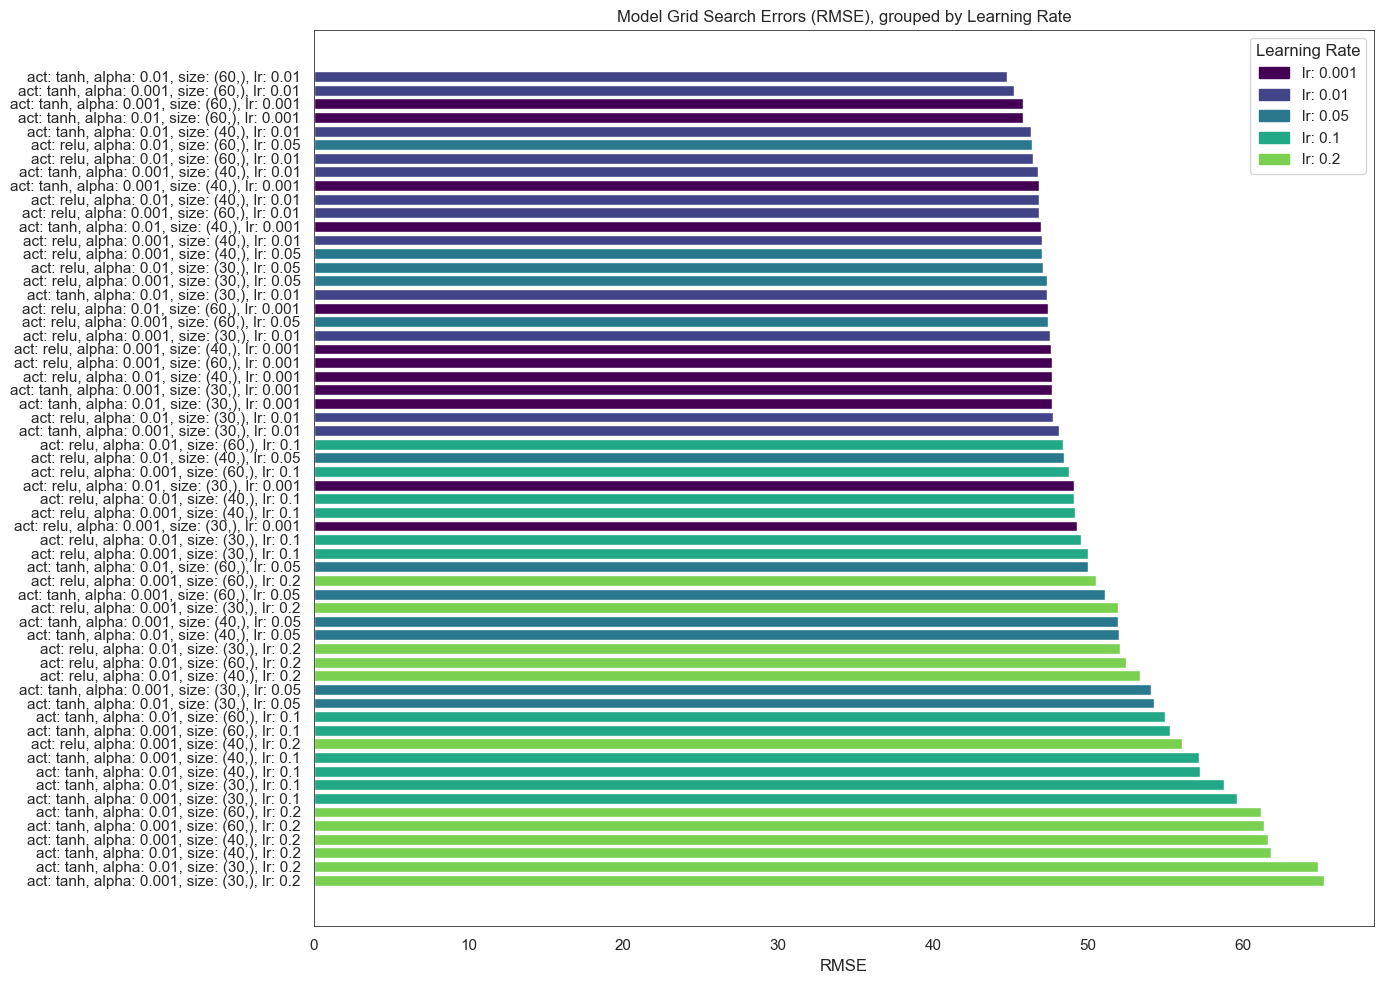

In [74]:
plotModelGridError(MLP_fit)
# La mejor combinación es ReLu, alpha=0.001, size=(60,), lr=0.1

In [ ]:
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])

In [ ]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

In [ ]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [ ]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()

In [ ]:
sensmlp.info()

In [ ]:
sensmlp.plot()

In [ ]:
ns.alpha_sens_curves(sensmlp)

In [ ]:
import inspect

In [ ]:
print(inspect.getsource(ns.alpha_sens_curves))